# LinearRegression on **Diamonds** dataset, with outliers

## Introduction

- In this project I apply the **LinearRegression** regressor on the **Diamonds** dataset from **OpenML**.
- The main reasons for chosing this dataset are: the presence of **outliers**, differenct feature scales, non-linear relationships and, features that are strongly corelated (e.g., **x, y, z, depth**).
- I chose this dataset as a challenge: **LinearRegression** is sensitive to outliers and multicollinearity, allowing me to explore methods of **preprocessing, feature engineering, and tranformations like log-scaling**.

In [27]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Loading and Exploring the Dataset

The dataset **Diamonds** is from [OpenML](https://www.openml.org/d/44979).
After loading the Dataset, I first inspect it to understand:
- The type of values (categorical vs numerical)
- The number of missing values (if any)
- The distribution and range of the target variable, in this case, the price

In [28]:
data = fetch_openml('diamonds', as_frame=True)

X = data.data
y = data.target

X, X.isna().sum(), y

(       carat        cut color clarity  depth  table     x     y     z
 0       0.23      Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43
 1       0.21    Premium     E     SI1   59.8   61.0  3.89  3.84  2.31
 2       0.23       Good     E     VS1   56.9   65.0  4.05  4.07  2.31
 3       0.29    Premium     I     VS2   62.4   58.0  4.20  4.23  2.63
 4       0.31       Good     J     SI2   63.3   58.0  4.34  4.35  2.75
 ...      ...        ...   ...     ...    ...    ...   ...   ...   ...
 53935   0.72      Ideal     D     SI1   60.8   57.0  5.75  5.76  3.50
 53936   0.72       Good     D     SI1   63.1   55.0  5.69  5.75  3.61
 53937   0.70  Very Good     D     SI1   62.8   60.0  5.66  5.68  3.56
 53938   0.86    Premium     H     SI2   61.0   58.0  6.15  6.12  3.74
 53939   0.75      Ideal     D     SI2   62.2   55.0  5.83  5.87  3.64
 
 [53940 rows x 9 columns],
 carat      0
 cut        0
 color      0
 clarity    0
 depth      0
 table      0
 x          0
 y          0
 z     

## Studying the Categorical Columns

After finding out what types of values are present, I list all the unqiue values in the **categorical columns** for encoding purposes.

In [29]:
list(X['cut'].unique()), list(X['color'].unique()), list(X['clarity'].unique())

(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'],
 ['E', 'I', 'J', 'H', 'F', 'G', 'D'],
 ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'])

## Creating Maps for encoding Categorical Values + Feature Engineering

In this step, I create a map for each non-numerical **column** to oncode its values in numeric form
This allows the model to interpret and use these features effectively during training.

For **Feature Engineering** sake, I created a **volume** column for clear representation of a value that strongly influences the price of a diamond, but, in the end, I got a lower score then before, so I did not keep this change. 
Because the **depth** column is calculated by the 'x', 'y', and 'z' values, I dropped the 3 columns because LinearRegression is senzitive to colinearity, but in practice it actually drops the accuracy score, for that reason I did not keep this change either.

My guess is that:
- The **'volume'** column did not help is because it is strongly related to the **'depth'** column.
- Dropping the 3 columns(**'x', 'y', 'z'**) had not positive efect because this **Dataset** only has 10 **Features** and does not suffer from colinearity at such a small scale.

In [30]:
cut_map = {'Fair' : 0, 'Good' : 1, 'Very Good' : 2, 'Premium' : 3, 'Ideal' : 4}
color_map = {'D' : 6, 'E' : 5, 'F' : 4, 'G' : 3, 'H' : 2, 'I' : 1, 'J' : 0}
clarity_map = {'I1' : 0, 'SI2' : 1, 'SI1' : 2, 'VS2' : 3, 'VS1' : 4, 'VVS2' : 5, 'VVS1' : 6, 'IF' : 7}

X['cut'] = X['cut'].map(cut_map)
X['color'] = X['color'].map(color_map)
X['clarity'] = X['clarity'].map(clarity_map)

#X['volume'] = X['x'] * X['y'] * X['z']
#X.drop(columns=['x', 'y', 'z'], inplace=True)
X


,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,4,6,2,60.8,57.0,5.75,5.76,3.50
53936,0.72,1,6,2,63.1,55.0,5.69,5.75,3.61
53937,0.70,2,6,2,62.8,60.0,5.66,5.68,3.56
53938,0.86,3,2,1,61.0,58.0,6.15,6.12,3.74


## Splitting the Data + Log-Scaling

I split the Data with a **train_test_split**. Although the **Diamonds** dataset has a couple of outliers, this simple split is sufficient for this project.
The main reason this aproach works well is the use of **Log-Scaling** to the target variable, as I later show, there is a significant improvement in model performance compared to training on the original, non-scaled target.
This improvement occurs because LinearRegression struggles when the target variable spans several orders of magnitude, and the **Log-Scaling** reduces the impact of extreme values.

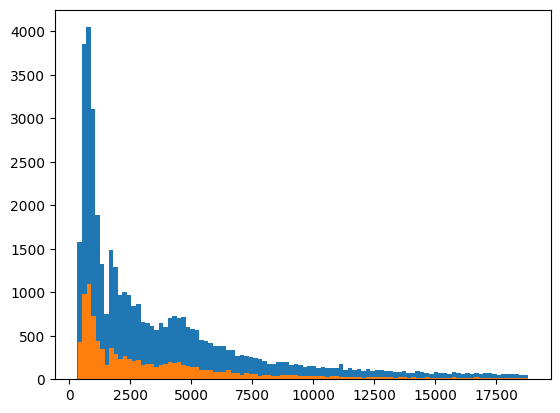

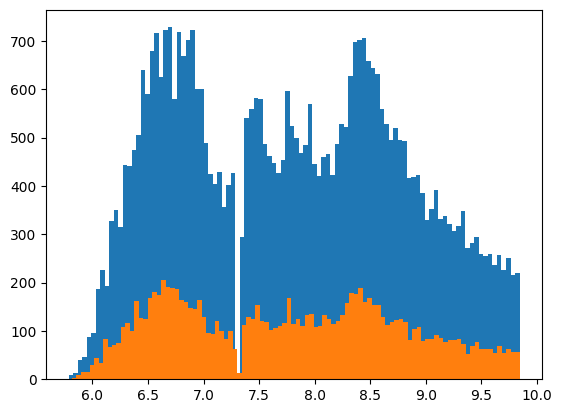

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

plt.hist(y_train, bins=100)
plt.hist(y_test, bins=100)
plt.show()

plt.hist(y_train_log, bins=100)
plt.hist(y_test_log, bins=100)
plt.show()

## Training the Model

In the next code cells I train two models:
- The first is without the **Log_Scaling**, getting a score of ≈0.90 and a graph which shows a **'exponential'** tendancy, rather than a the linear **'y = x'** ideal prediction line, this issue is adressed in the second model.
- The second model uses log-scaled target, which removes skewness, getting a drastic improvement to ≈0.97, and rather **'linear'** trend, way closer to the perfect prediction line.

In [32]:
model = LinearRegression()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9056643685073511

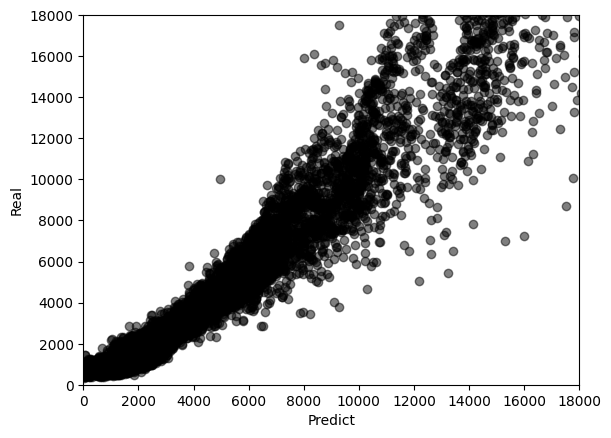

In [33]:
y_pred = model.predict(X_test)

plt.scatter(y_pred, y_test, alpha=0.5, color='black')
plt.xlim(0,18000)
plt.ylim(0,18000)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()

In [34]:
model_log = LinearRegression()

model_log.fit(X_train, y_train_log)

model_log.score(X_test, y_test_log)

0.9696376306711508

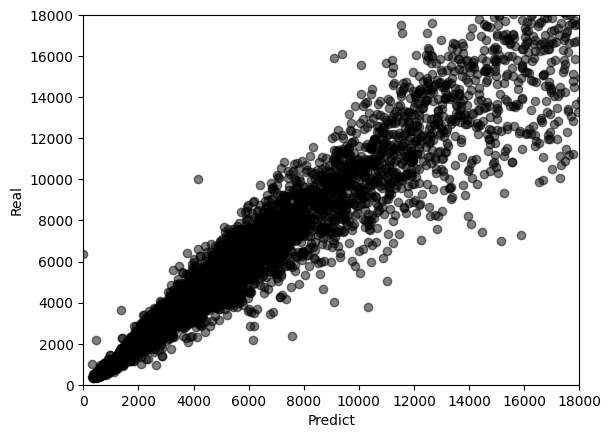

In [35]:
y_pred_log = model_log.predict(X_test)
y_pred = np.exp(y_pred_log)

plt.scatter(y_pred, y_test, alpha=0.5, color='black')
plt.xlim(0,18000)
plt.ylim(0,18000)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()

# Conclusion

I have found that understanding the **core principles** of the model and visualizing the data to identify **possible issues**, are among the most important factors for improving model performance.